In [2]:
#import packages
import geopandas as gpd
import osmnx as ox
import shapely 

#import shapely speedups
from shapely import speedups
speedups.enabled

True

In [3]:
#import exits
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')

In [7]:
#Reveal the coordinate reference system
exits_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
#Transform exits to UTM17N
exits_gdf = exits_gdf.to_crs(32617)
print(exits_gdf.crs)

epsg:32617


In [15]:
#Buffer point features 1 mile
exits_gdf['geometry'] = exits_gdf['geometry'].buffer(1609.34)

In [17]:
#Transform buffer back to WGS84
exits_gdf_wgs84 = exits_gdf.to_crs(4326)

In [18]:
theSearchArea = exits_gdf_wgs84['geometry'].unary_union
type(theSearchArea)

shapely.geometry.multipolygon.MultiPolygon

In [20]:
theAmenities = ox.pois.create_poi_gdf(polygon=theSearchArea,
                                      amenities=['restaurant','cafe'])

In [21]:
#Save to csv
theAmenities.to_csv('../Data/OSM/Amenities_1mile.csv')

In [24]:
theAmenities['geometry'].type.unique()

array(['Point', 'Polygon', 'MultiPolygon'], dtype=object)

In [25]:
#Split into two dataframes on geometry
theAmenities_points = theAmenities.loc[theAmenities['geometry'].type == "Point"].reset_index()
theAmenities_polys = theAmenities.loc[theAmenities['geometry'].type != "Point"].reset_index()

In [29]:
theAmenities_polys['geometry'] = theAmenities_polys['geometry'].centroid

In [30]:
theAmenities_polys['geometry'].type.unique()

array(['Point'], dtype=object)

In [31]:
import pandas as pd
theAmenities_all = pd.concat([theAmenities_points,theAmenities_polys])
theAmenities_all.shape

(1531, 228)

In [35]:
theAmenities_all[['amenity','geometry']].to_file('../Data/OSM/OSM_amenities.shp')

#### Count amenites near a feature

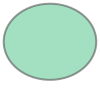

In [36]:
theArea = exits_gdf_wgs84.at[56,'geometry']
theArea

In [38]:
theAmenities_all.within(theArea).sum()

2

In [39]:
def get_amenity_count(theShape):
    return theAmenities_all.within(theShape).sum()

In [40]:
amenity_count = exits_gdf_wgs84['geometry'].apply(get_amenity_count)

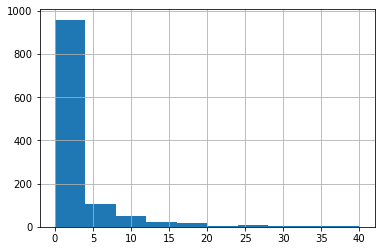

In [42]:
amenity_count.hist();

In [43]:
exit_gdf = gpd.read_file('../Data/MJBA/Exits.shp')
exit_gdf['amenity_n'] = amenity_count
exit_gdf.head()

,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,geometry,amenity_n
0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,POINT (-84.31430 35.01949),0
1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,POINT (-84.31149 35.01493),0
2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,POINT (-84.29553 35.01356),0
3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,POINT (-84.28029 35.01288),0
4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,POINT (-84.27519 35.01782),0


In [44]:
exit_gdf.to_file('../Data/processed/exits_amenities.shp')

In [45]:
#Import contextily 
import contextily as ctx

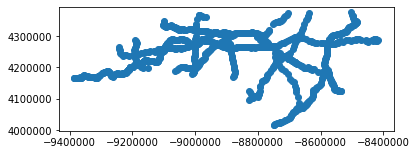

In [47]:
#Transform to web mercator (to match contextily base maps)
exits_gdf_wm = exit_gdf.to_crs(3857)
exits_gdf_wm.plot()

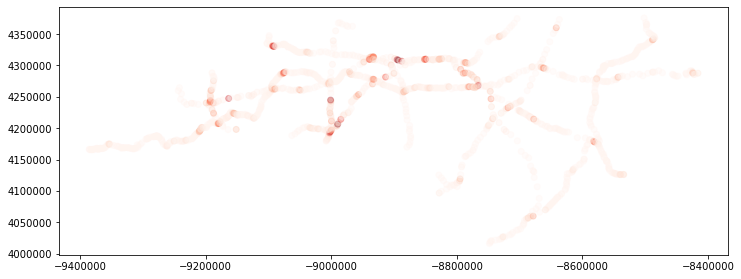

In [51]:
exits_gdf_wm.plot('amenity_n',alpha=0.3,figsize=(12,6),cmap='Reds')

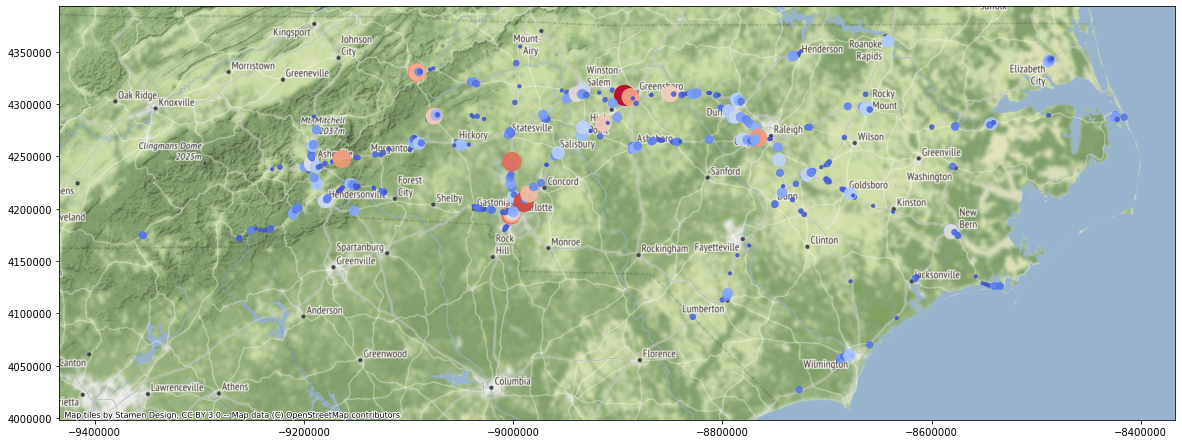

In [54]:
#Plot the amenities to an axis called 'ax'
ax =exits_gdf_wm.plot('amenity_n',
                      cmap='coolwarm',
                      markersize= exits_gdf_wm['amenity_n']*10,
                      alpha=0.9,
                      figsize=(20,10));
# Add basemap
ctx.add_basemap(ax)

In [55]:
#import matplotlib.pyplot as plt
import mplleaflet

In [57]:
#Plot the amenities to an axis called 'ax'
ax =exit_gdf.to_crs(4326).plot('amenity_n',
                      cmap='coolwarm',
                      markersize= exit_gdf['amenity_n']*10,
                      alpha=0.9,
                      figsize=(20,10));
# 2. Convert plot to a web map and show in a new page
mplleaflet.show(fig=ax.figure)